In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects


file_path = r"E:\Projects\Gamezone Orders Data\gamezone_orders_data_cleaned.csv"
df = pd.read_csv(
    file_path,
    parse_dates=['purchase_ts_cleaned', 'ship_ts'],
    dtype={
        'purchase_year': 'Int64',
        'purchase_month': 'Int64',
        'time_to_ship': 'Int64',
        'revenue': 'float'
    },
    encoding='utf-8',
    keep_default_na=False,
    na_values=['']  # Only treat empty strings as NaN
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21864 entries, 0 to 21863
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   user_id                          21864 non-null  object        
 1   order_id                         21864 non-null  object        
 2   purchase_ts                      21864 non-null  object        
 3   purchase_ts_cleaned              21863 non-null  datetime64[ns]
 4   purchase_year                    21864 non-null  Int64         
 5   purchase_month                   21864 non-null  Int64         
 6   time_to_ship                     21864 non-null  Int64         
 7   ship_ts                          21864 non-null  datetime64[ns]
 8   product_name                     21864 non-null  object        
 9   product_name_cleaned             21864 non-null  object        
 10  product_id                       21864 non-null  object   

In [4]:
from collections import deque

# Prepare data
df['purchase_ts_cleaned'] = pd.to_datetime(df['purchase_ts_cleaned'])
df = df.sort_values('purchase_ts_cleaned')

# Create complete daily grid
date_range = pd.date_range(
    start=df['purchase_ts_cleaned'].min().floor('D'),
    end=df['purchase_ts_cleaned'].max().floor('D'),
    freq='D'
)

daily_users = (
    df.groupby(df['purchase_ts_cleaned'].dt.floor('D'))['user_id']
    .agg(lambda x: set(x))
    .reindex(date_range, fill_value=set())
    .reset_index()
    .rename(columns={'index': 'date', 'user_id': 'user_set'})
)

# Rolling 30-day MAB (optimized)
rolling_window = deque(maxlen=30)
mab_values = []

for user_set in daily_users['user_set']:
    rolling_window.append(user_set)
    
    if len(rolling_window) < 30:
        mab_values.append(None)
    else:
        mab_values.append(len(set().union(*rolling_window)))

daily_users['monthly_active_buyers'] = mab_values

# Extract date components
daily_users['year'] = daily_users['date'].dt.year
daily_users['month_num'] = daily_users['date'].dt.month
daily_users['month_name'] = daily_users['date'].dt.strftime('%b')

# Get month-end MAB values
monthly_mab = (
    daily_users[daily_users['monthly_active_buyers'].notna()]
    .groupby(['year', 'month_num', 'month_name'], as_index=False)  # Keep month_num
    .last()
    [['year', 'month_num', 'month_name', 'monthly_active_buyers']]  # Include month_num
    .sort_values(['year', 'month_num'])  # Now it exists!
)

# Optional: Drop month_num if you don't need it in output
# monthly_mab = monthly_mab.drop(columns=['month_num'])

monthly_mab

,year,month_num,month_name,monthly_active_buyers
0,2019,1,Jan,399.0
1,2019,2,Feb,345.0
2,2019,3,Mar,503.0
3,2019,4,Apr,530.0
4,2019,5,May,487.0
5,2019,6,Jun,474.0
6,2019,7,Jul,484.0
7,2019,8,Aug,502.0
8,2019,9,Sep,577.0
9,2019,10,Oct,473.0


In [37]:
monthly_mab

,year,month_num,month_name,monthly_active_buyers,month_year,mom_pct
0,2019,1,Jan,399.0,Jan-2019,NaN
1,2019,2,Feb,345.0,Feb-2019,-13.533835
2,2019,3,Mar,503.0,Mar-2019,45.797101
3,2019,4,Apr,530.0,Apr-2019,5.367793
4,2019,5,May,487.0,May-2019,-8.113208
5,2019,6,Jun,474.0,Jun-2019,-2.669405
6,2019,7,Jul,484.0,Jul-2019,2.109705
7,2019,8,Aug,502.0,Aug-2019,3.719008
8,2019,9,Sep,577.0,Sep-2019,14.940239
9,2019,10,Oct,473.0,Oct-2019,-18.024263


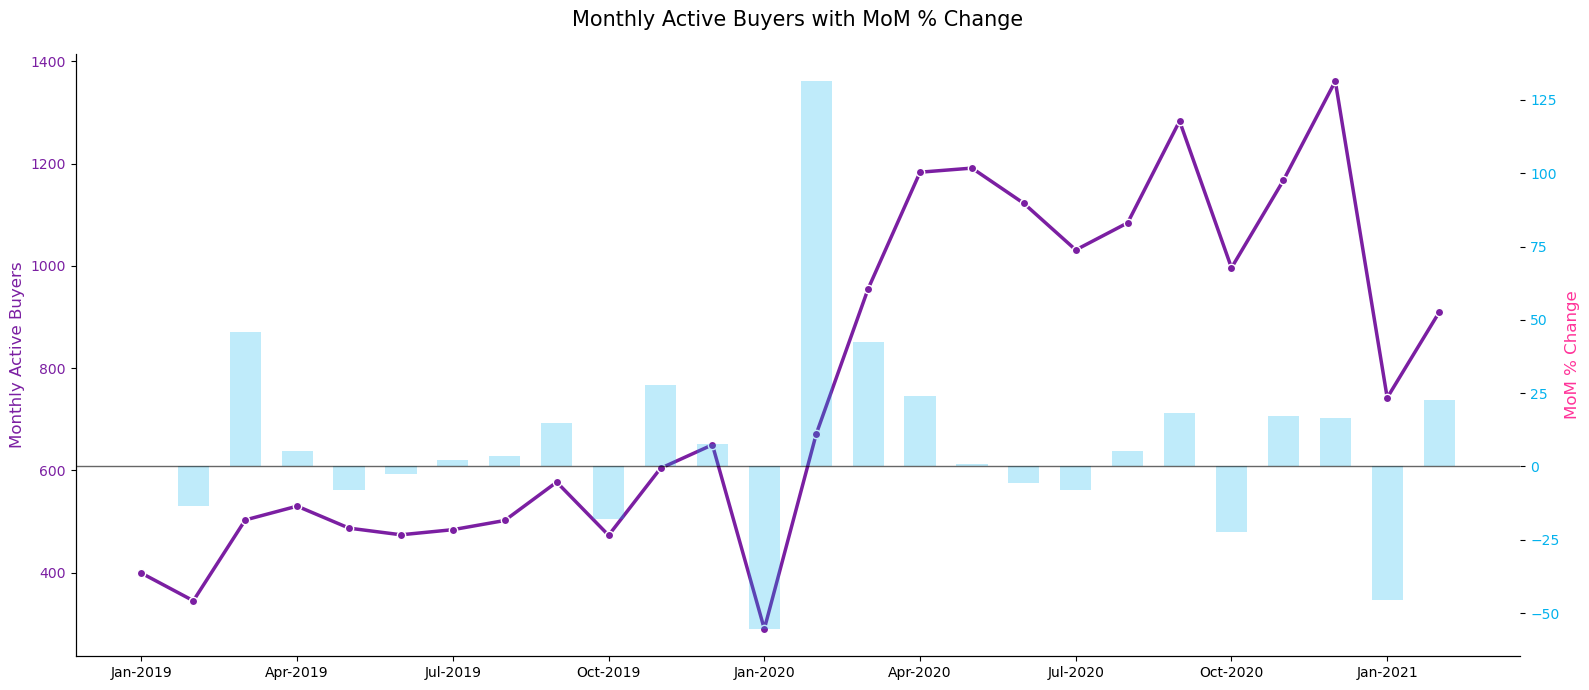

In [16]:
colors = ["#7B1FA2", "#03b2ed", "#FF3399"]

# ---- Calculate MoM % ----
monthly_mab["mom_pct"] = (
    monthly_mab["monthly_active_buyers"].pct_change() * 100
)

# Month-Year label
monthly_mab["month_year"] = (
    monthly_mab["month_name"] + "-" + monthly_mab["year"].astype(str)
)

# Quarter ticks (Jan, Apr, Jul, Oct)
quarter_filter = monthly_mab["month_num"].isin([1, 4, 7, 10])
xticks = monthly_mab.index[quarter_filter]
xtick_labels = monthly_mab.loc[quarter_filter, "month_year"]

# ---- Plot ----
fig, ax1 = plt.subplots(figsize=(16, 7))

# -----------------------------
#   LINE CHART — MAB
# -----------------------------
ax1.plot(
    monthly_mab["monthly_active_buyers"],
    color=colors[0],
    linewidth=2.5,
    marker="o",
    markersize=6,
    markeredgecolor="white"
)
ax1.set_ylabel("Monthly Active Buyers", fontsize=12, color=colors[0])
ax1.tick_params(axis="y", labelcolor=colors[0])

# Remove gridlines
ax1.grid(False)

# -----------------------------
#   BAR CHART — MoM %
# -----------------------------
ax2 = ax1.twinx()

ax2.bar(
    monthly_mab.index,
    monthly_mab["mom_pct"],
    color=colors[1],
    alpha=0.25,
    width=0.6
)

ax2.axhline(0, color="black", linewidth=1, alpha=0.6)
ax2.set_ylabel("MoM % Change", fontsize=12, color=colors[2])
ax2.tick_params(axis="y", labelcolor=colors[1])

# -----------------------------
#   X-AXIS SETTINGS
# -----------------------------
plt.xticks(xticks, xtick_labels, fontsize=10)
plt.xlabel("")

# Clean borders
for spine in ["top", "right"]:
    ax1.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)

plt.title("Monthly Active Buyers with MoM % Change", fontsize=15, pad=20)

plt.tight_layout()
plt.show()


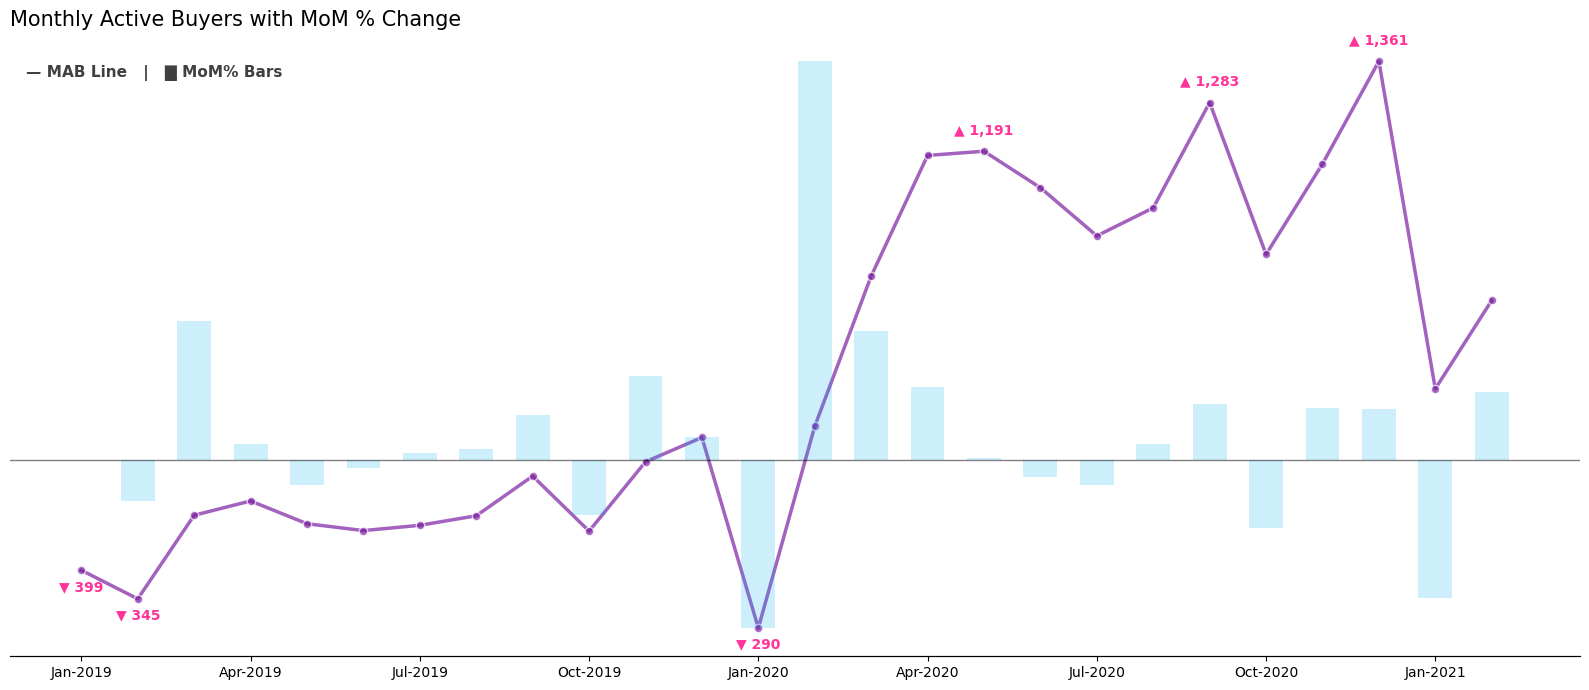

In [26]:
import matplotlib.pyplot as plt
import numpy as np

colors = ["#7B1FA2", "#03b2ed", "#FF3399"]

# ---- Calculate MoM % ----
monthly_mab["mom_pct"] = monthly_mab["monthly_active_buyers"].pct_change() * 100

# Month-Year label
monthly_mab["month_year"] = (
    monthly_mab["month_name"] + "-" + monthly_mab["year"].astype(str)
)

# Quarter ticks
quarter_filter = monthly_mab["month_num"].isin([1, 4, 7, 10])
xticks = monthly_mab.index[quarter_filter]
xtick_labels = monthly_mab.loc[quarter_filter, "month_year"]

# ---- Identify top 3 & bottom 3 ----
vals = monthly_mab["monthly_active_buyers"]
top3_idx = vals.nlargest(3).index
bottom3_idx = vals.nsmallest(3).index

# ---- PLOT ----
fig, ax1 = plt.subplots(figsize=(16, 7))

# -----------------------------
#   LINE — MAB
# -----------------------------
ax1.plot(
    monthly_mab["monthly_active_buyers"],
    color=colors[0],
    linewidth=2.5,
    alpha=0.7,
    marker="o",
    markersize=6,
    markeredgecolor="white",
    label="Monthly Active Buyers (Line)"
)

# -----------------------------
#   BAR — MoM %
# -----------------------------
ax2 = ax1.twinx()
ax2.bar(
    monthly_mab.index,
    monthly_mab["mom_pct"],
    color=colors[1],
    alpha=0.20,
    width=0.6,
    label="MoM % Change (Bar)"
)
ax2.axhline(0, color="black", linewidth=1, alpha=0.5)

# ---------------------------------------------------
#  REMOVE BOTH Y AXES
# ---------------------------------------------------
ax1.set_yticks([])
ax2.set_yticks([])
ax1.set_ylabel("")
ax2.set_ylabel("")

# ---------------------------------------------------
# LABEL highest & lowest 3 points
# ---------------------------------------------------
for i in top3_idx:
    ax1.annotate(
        f"▲ {vals[i]:,.0f}",
        (i, vals[i]),
        xytext=(0, 12),
        textcoords="offset points",
        ha="center",
        fontsize=10,
        fontweight="bold",
        color=colors[2]
    )

for i in bottom3_idx:
    ax1.annotate(
        f"▼ {vals[i]:,.0f}",
        (i, vals[i]),
        xytext=(0, -15),
        textcoords="offset points",
        ha="center",
        fontsize=10,
        fontweight="bold",
        color=colors[2]
    )

# -----------------------------
#   X-axis
# -----------------------------
plt.xticks(xticks, xtick_labels, fontsize=10)
plt.xlabel("")

# -----------------------------
#   Remove chart borders
# -----------------------------
for spine in ["top", "right", "left"]:
    ax1.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)

# -----------------------------
# -----------------------------
#   TITLE — Move to left
# -----------------------------
plt.title(
    "Monthly Active Buyers with MoM % Change",
    fontsize=15,
    pad=5,          # smaller gap so legend stays close
    loc="left"
)

# -----------------------------
#   LEGEND Beneath Title (clean, left aligned)
# -----------------------------
fig.canvas.draw()   # ensures title position is known

title_y = plt.gca().title.get_position()[1]   # get title Y coordinate

plt.text(
    0.01, title_y - 0.07,                      # place legend just below title
    "— MAB Line   |   █ MoM% Bars",
    transform=plt.gca().transAxes,
    fontsize=11,
    fontweight="bold",
    alpha=0.75
)


plt.tight_layout()
plt.show()


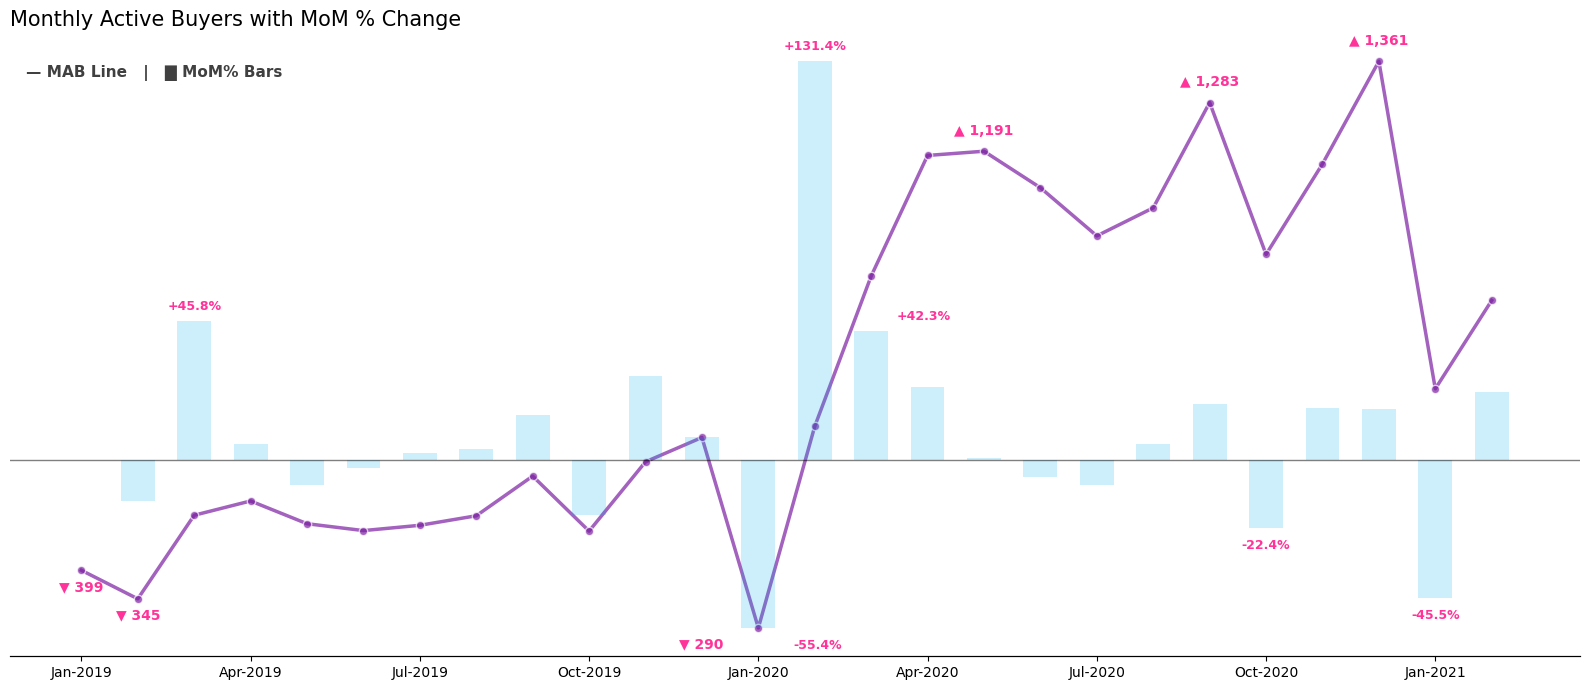

In [38]:
import matplotlib.pyplot as plt
import numpy as np

colors = ["#7B1FA2", "#03b2ed", "#FF3399"]

# ---- Calculate MoM % ----
monthly_mab["mom_pct"] = monthly_mab["monthly_active_buyers"].pct_change() * 100

# Month-Year label
monthly_mab["month_year"] = (
    monthly_mab["month_name"] + "-" + monthly_mab["year"].astype(str)
)

# Quarter ticks
quarter_filter = monthly_mab["month_num"].isin([1, 4, 7, 10])
xticks = monthly_mab.index[quarter_filter]
xtick_labels = monthly_mab.loc[quarter_filter, "month_year"]

# ---- Identify top & bottom 3 for MAB ----
vals = monthly_mab["monthly_active_buyers"]
top3_idx = vals.nlargest(3).index
bottom3_idx = vals.nsmallest(3).index

# TRUE bottom-most MAB
bottom_mab_idx = vals.idxmin()

# ---- Identify top & bottom 3 GROWTH bars (MoM %) ----
mom_vals = monthly_mab["mom_pct"]
top3_mom = mom_vals.nlargest(3).index
bottom3_mom = mom_vals.nsmallest(3).index

# TRUE bottom-most MoM
bottom_mom_idx = mom_vals.idxmin()

# ---- PLOT ----
fig, ax1 = plt.subplots(figsize=(16, 7))

# LINE — MAB
ax1.plot(
    monthly_mab["monthly_active_buyers"],
    color=colors[0],
    linewidth=2.5,
    alpha=0.7,
    marker="o",
    markersize=6,
    markeredgecolor="white",
    label="Monthly Active Buyers (Line)"
)

# BAR — MoM %
ax2 = ax1.twinx()
ax2.bar(
    monthly_mab.index,
    monthly_mab["mom_pct"],
    color=colors[1],
    alpha=0.20,
    width=0.6,
    label="MoM % Change (Bar)"
)
ax2.axhline(0, color="black", linewidth=1, alpha=0.5)

# ---- REMOVE Y-AXES ----
ax1.set_yticks([])
ax2.set_yticks([])
ax1.set_ylabel("")
ax2.set_ylabel("")

# ---- LABEL highest & lowest 3 MAB points ----
for i in top3_idx:
    ax1.annotate(
        f"▲ {vals[i]:,.0f}",
        (i, vals[i]),
        xytext=(0, 12),
        textcoords="offset points",
        ha="center",
        fontsize=10,
        fontweight="bold",
        color=colors[2]
    )

for i in bottom3_idx:
    ax1.annotate(
        f"▼ {vals[i]:,.0f}",
        (i, vals[i]),
        xytext=(-25 if i == bottom_mab_idx else 0, -15),
        textcoords="offset points",
        ha="right" if i == bottom_mab_idx else "center",
        fontsize=10,
        fontweight="bold",
        color=colors[2]
    )

# ---- LABEL highest & lowest 3 GROWTH bars ----
for i in top3_mom:
    value = mom_vals[i]

    # shift ONLY index 14 (42.3%) by 0.5cm right
    if i == 14:
        ax2.annotate(
            f"+{value:.1f}%",
            (i, value),
            xytext=(18, 8),        # 0.5 cm right shift
            textcoords="offset points",
            ha="left",
            fontsize=9,
            fontweight="bold",
            color=colors[2]
        )
    else:
        ax2.annotate(
            f"+{value:.1f}%",
            (i, value),
            xytext=(0, 8),
            textcoords="offset points",
            ha="center",
            fontsize=9,
            fontweight="bold",
            color=colors[2]
        )

for i in bottom3_mom:
    value = mom_vals[i]

    ax2.annotate(
        f"{value:.1f}%",
        (i, value),
        xytext=(25 if i == bottom_mom_idx else 0, -15),
        textcoords="offset points",
        ha="left" if i == bottom_mom_idx else "center",
        fontsize=9,
        fontweight="bold",
        color=colors[2]
    )

# X-axis
plt.xticks(xticks, xtick_labels, fontsize=10)
plt.xlabel("")

# Remove chart borders
for spine in ["top", "right", "left"]:
    ax1.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)

# TITLE
plt.title(
    "Monthly Active Buyers with MoM % Change",
    fontsize=15,
    pad=5,
    loc="left"
)

# LEGEND under title
fig.canvas.draw()
title_y = plt.gca().title.get_position()[1]

plt.text(
    0.01, title_y - 0.07,
    "— MAB Line   |   █ MoM% Bars",
    transform=plt.gca().transAxes,
    fontsize=11,
    fontweight="bold",
    alpha=0.75
)

plt.tight_layout()
plt.show()


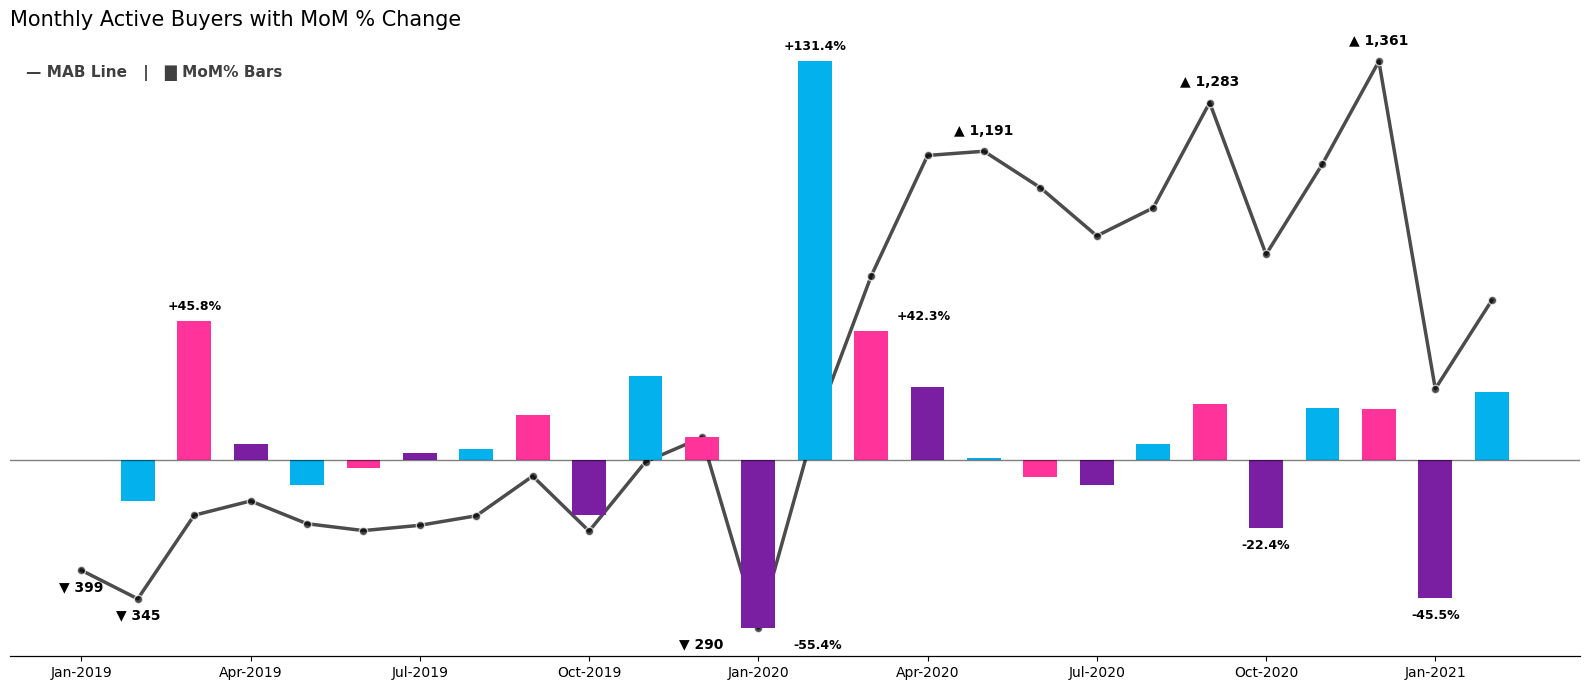

In [5]:
import matplotlib.pyplot as plt
import numpy as np

colors = ["#7B1FA2", "#03b2ed", "#FF3399"]  # gradient colors

# ---- Calculate MoM % ----
monthly_mab["mom_pct"] = monthly_mab["monthly_active_buyers"].pct_change() * 100

# Month-Year label
monthly_mab["month_year"] = monthly_mab["month_name"] + "-" + monthly_mab["year"].astype(str)

# Quarter ticks
quarter_filter = monthly_mab["month_num"].isin([1, 4, 7, 10])
xticks = monthly_mab.index[quarter_filter]
xtick_labels = monthly_mab.loc[quarter_filter, "month_year"]

# ---- Identify top & bottom 3 for MAB ----
vals = monthly_mab["monthly_active_buyers"]
top3_idx = vals.nlargest(3).index
bottom3_idx = vals.nsmallest(3).index
bottom_mab_idx = vals.idxmin()

# ---- Identify top & bottom 3 GROWTH bars (MoM %) ----
mom_vals = monthly_mab["mom_pct"]
top3_mom = mom_vals.nlargest(3).index
bottom3_mom = mom_vals.nsmallest(3).index
bottom_mom_idx = mom_vals.idxmin()

# ---- PLOT ----
fig, ax1 = plt.subplots(figsize=(16, 7))

# LINE — MAB (black)
ax1.plot(
    monthly_mab["monthly_active_buyers"],
    color="black",
    linewidth=2.5,
    alpha=0.7,
    marker="o",
    markersize=6,
    markeredgecolor="white",
    label="Monthly Active Buyers (Line)"
)

# BAR — MoM % with gradient
ax2 = ax1.twinx()
num_bars = len(monthly_mab)
bar_colors = [colors[i % 3] for i in range(num_bars)]  # repeat gradient
ax2.bar(
    monthly_mab.index,
    monthly_mab["mom_pct"],
    color=bar_colors,
    width=0.6,
    label="MoM % Change (Bar)"
)
ax2.axhline(0, color="black", linewidth=1, alpha=0.5)

# ---- REMOVE Y-AXES ----
ax1.set_yticks([])
ax2.set_yticks([])
ax1.set_ylabel("")
ax2.set_ylabel("")

# ---- LABEL highest & lowest 3 MAB points (black) ----
for i in top3_idx:
    ax1.annotate(
        f"▲ {vals[i]:,.0f}",
        (i, vals[i]),
        xytext=(0, 12),
        textcoords="offset points",
        ha="center",
        fontsize=10,
        fontweight="bold",
        color="black"
    )

for i in bottom3_idx:
    ax1.annotate(
        f"▼ {vals[i]:,.0f}",
        (i, vals[i]),
        xytext=(-25 if i == bottom_mab_idx else 0, -15),
        textcoords="offset points",
        ha="right" if i == bottom_mab_idx else "center",
        fontsize=10,
        fontweight="bold",
        color="black"
    )

# ---- LABEL highest & lowest 3 GROWTH bars (black) ----
for i in top3_mom:
    value = mom_vals[i]
    if i == 14:  # specific shift
        ax2.annotate(f"+{value:.1f}%", (i, value), xytext=(18, 8), textcoords="offset points",
                     ha="left", fontsize=9, fontweight="bold", color="black")
    else:
        ax2.annotate(f"+{value:.1f}%", (i, value), xytext=(0, 8), textcoords="offset points",
                     ha="center", fontsize=9, fontweight="bold", color="black")

for i in bottom3_mom:
    value = mom_vals[i]
    ax2.annotate(f"{value:.1f}%", (i, value), xytext=(25 if i == bottom_mom_idx else 0, -15),
                 textcoords="offset points", ha="left" if i == bottom_mom_idx else "center",
                 fontsize=9, fontweight="bold", color="black")

# X-axis
plt.xticks(xticks, xtick_labels, fontsize=10)
plt.xlabel("")

# Remove chart borders
for spine in ["top", "right", "left"]:
    ax1.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)

# TITLE
plt.title(
    "Monthly Active Buyers with MoM % Change",
    fontsize=15,
    pad=5,
    loc="left"
)

# LEGEND under title
fig.canvas.draw()
title_y = plt.gca().title.get_position()[1]

plt.text(
    0.01, title_y - 0.07,
    "— MAB Line   |   █ MoM% Bars",
    transform=plt.gca().transAxes,
    fontsize=11,
    fontweight="bold",
    alpha=0.75
)

plt.tight_layout()
plt.show()


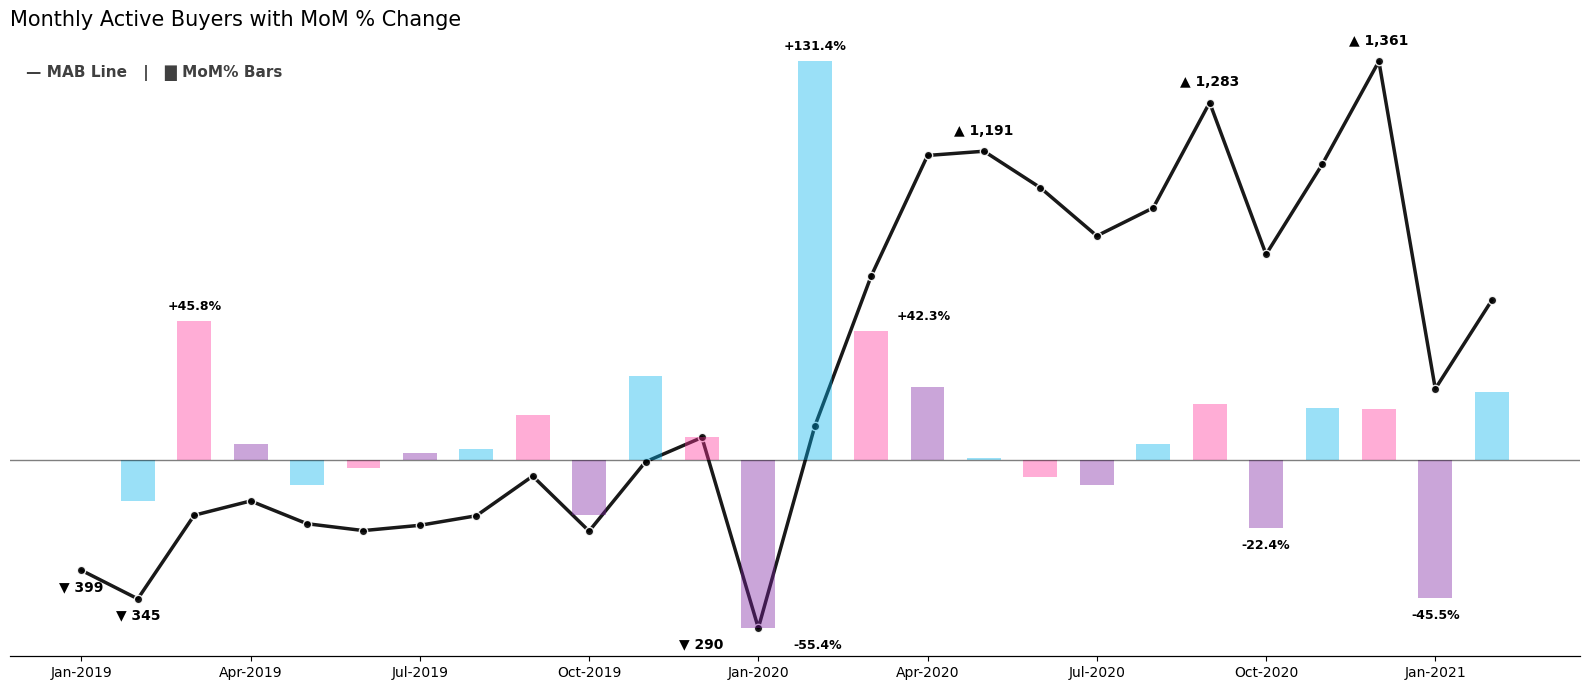

In [8]:
import matplotlib.pyplot as plt
import numpy as np

colors = ["#7B1FA2", "#03b2ed", "#FF3399"]  # gradient colors

# ---- Calculate MoM % ----
monthly_mab["mom_pct"] = monthly_mab["monthly_active_buyers"].pct_change() * 100

# Month-Year label
monthly_mab["month_year"] = monthly_mab["month_name"] + "-" + monthly_mab["year"].astype(str)

# Quarter ticks
quarter_filter = monthly_mab["month_num"].isin([1, 4, 7, 10])
xticks = monthly_mab.index[quarter_filter]
xtick_labels = monthly_mab.loc[quarter_filter, "month_year"]

# ---- Identify top & bottom 3 for MAB ----
vals = monthly_mab["monthly_active_buyers"]
top3_idx = vals.nlargest(3).index
bottom3_idx = vals.nsmallest(3).index
bottom_mab_idx = vals.idxmin()

# ---- Identify top & bottom 3 GROWTH bars (MoM %) ----
mom_vals = monthly_mab["mom_pct"]
top3_mom = mom_vals.nlargest(3).index
bottom3_mom = mom_vals.nsmallest(3).index
bottom_mom_idx = mom_vals.idxmin()

# ---- PLOT ----
fig, ax1 = plt.subplots(figsize=(16, 7))

# BAR — MoM % with gradient & translucency
ax2 = ax1.twinx()
num_bars = len(monthly_mab)
bar_colors = [colors[i % 3] for i in range(num_bars)]  # repeat gradient
bars = ax2.bar(
    monthly_mab.index,
    monthly_mab["mom_pct"],
    color=bar_colors,
    width=0.6,
    alpha=0.4,  # make bars translucent
    label="MoM % Change (Bar)"
)
ax2.axhline(0, color="black", linewidth=1, alpha=0.5)

# LINE — MAB (black) on top
line, = ax1.plot(
    monthly_mab["monthly_active_buyers"],
    color="black",
    linewidth=2.5,
    alpha=0.9,
    marker="o",
    markersize=6,
    markeredgecolor="white",
    label="Monthly Active Buyers (Line)",
    zorder=5  # ensures line is on top of bars
)

# ---- REMOVE Y-AXES ----
ax1.set_yticks([])
ax2.set_yticks([])
ax1.set_ylabel("")
ax2.set_ylabel("")

# ---- LABEL highest & lowest 3 MAB points (black) ----
for i in top3_idx:
    ax1.annotate(f"▲ {vals[i]:,.0f}", (i, vals[i]),
                 xytext=(0, 12), textcoords="offset points",
                 ha="center", fontsize=10, fontweight="bold", color="black")

for i in bottom3_idx:
    ax1.annotate(f"▼ {vals[i]:,.0f}", (i, vals[i]),
                 xytext=(-25 if i == bottom_mab_idx else 0, -15), textcoords="offset points",
                 ha="right" if i == bottom_mab_idx else "center",
                 fontsize=10, fontweight="bold", color="black")

# ---- LABEL highest & lowest 3 GROWTH bars (black) ----
for i in top3_mom:
    value = mom_vals[i]
    if i == 14:  # specific shift
        ax2.annotate(f"+{value:.1f}%", (i, value), xytext=(18, 8), textcoords="offset points",
                     ha="left", fontsize=9, fontweight="bold", color="black")
    else:
        ax2.annotate(f"+{value:.1f}%", (i, value), xytext=(0, 8), textcoords="offset points",
                     ha="center", fontsize=9, fontweight="bold", color="black")

for i in bottom3_mom:
    value = mom_vals[i]
    ax2.annotate(f"{value:.1f}%", (i, value), xytext=(25 if i == bottom_mom_idx else 0, -15),
                 textcoords="offset points", ha="left" if i == bottom_mom_idx else "center",
                 fontsize=9, fontweight="bold", color="black")

# X-axis
plt.xticks(xticks, xtick_labels, fontsize=10)
plt.xlabel("")

# Remove chart borders
for spine in ["top", "right", "left"]:
    ax1.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)

# TITLE
plt.title("Monthly Active Buyers with MoM % Change", fontsize=15, pad=5, loc="left")

# LEGEND under title
fig.canvas.draw()
title_y = plt.gca().title.get_position()[1]

plt.text(0.01, title_y - 0.07,
         "— MAB Line   |   █ MoM% Bars",
         transform=plt.gca().transAxes,
         fontsize=11, fontweight="bold", alpha=0.75)

plt.tight_layout()
plt.show()
